# 1. Data input

In [1]:

import json
import random
from sklearn import svm

train_data_raw = []
test_data_raw = []

cuisine_dict = {}
ing_dict = {}
count_dict = {}

with open('train.json') as json_file:
    train_data_raw = json.load(json_file)

with open('test.json') as json_file:
    test_data_raw = json.load(json_file)

# generate one-hot encoding
for item in train_data_raw:
    # calculate cuisine type and the total number of them
    if item['cuisine'] not in cuisine_dict:
        cuisine_dict[item['cuisine']] = len(cuisine_dict)

    # calculate number and type of ingredient
    for ingr in item['ingredients']:
        if ingr not in ing_dict:
            ing_dict[ingr] = len(ing_dict)
            count_dict[ingr] = 1
        else:
            count_dict[ingr] += 1


# 2. Data preprocessing

In [2]:
from sklearn.model_selection import train_test_split
train_data_list = []
test_data_list = []
x_list_train = []
y_list_train = []
x_list_test = []
y_list_id = []

predict_result = []


for item in train_data_raw:
    buf = []
    for ingr in item['ingredients']:
        buf.append(ingr)

    # the list of feature + target
    buf.append(item['cuisine'])
    train_data_list.append(buf)

random.shuffle(train_data_list)

for item in test_data_raw:
    buf = []
    for ingr in item['ingredients']:
        buf.append(ingr)

    # the list of feature
    buf.append(item['id'])
    test_data_list.append(buf)

random.shuffle(test_data_list)



# change all the categorical feature to numerical feature with a dictionary which map ingredient to number
for cuisine_now in train_data_list:
    buf = []
    for key,value in ing_dict.items():
        if key in cuisine_now:
            buf.append(1)
        else:
            buf.append(0)
    x_list_train.append(buf)
    y_list_train.append(cuisine_dict[cuisine_now[-1]])

for cuisine_now in test_data_list:
    buf = []
    for key,value in ing_dict.items():
        if key in cuisine_now:
            buf.append(1)
        else:
            buf.append(0)
    x_list_test.append(buf)
    y_list_id.append(cuisine_now[-1])
    

# holdout validation with train-test ratio 7:3
train_x, valid_x, train_y, valid_y = train_test_split(x_list_train, y_list_train, test_size = 0.3)


print("Data preprocessing done")


Data preprocessing done


# 3. Model construction & validation

## SVM

In [6]:
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import math
import time

svm_rbf = svm.SVC(C=100,kernel='rbf')

start_time = time.time()
svm_rbf.fit(x_list_train,y_list_train)


predict_result_svm = svm_rbf.predict(x_list_test)
predict_result_svm_test = svm_rbf.predict(valid_x)


print("execution time : ",time.time()-start_time)

execution time :  11310.176713228226


## ANN

In [24]:
import tensorflow as tf
from keras import models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import utils

model = models.Sequential()

model.add(Dense(units = len(ing_dict)*0.5,input_dim = len(ing_dict), kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.2))
#model.add(Dense(units = len(ing_dict)*0.2, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(units = len(cuisine_dict), kernel_initializer = 'normal', activation = 'softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_history = model.fit(x_list_train, y_list_train, epochs=20, batch_size = 64,verbose = 2)
score = model.evaluate(valid_x, valid_y)


predict_result_ann = model.predict_classes(x_list_test)
predict_result_ann_test = model.predict_classes(valid_x)


Epoch 1/20
466/466 - 71s - loss: 0.9811 - accuracy: 0.7222
Epoch 2/20
466/466 - 65s - loss: 0.3950 - accuracy: 0.8853
Epoch 3/20
466/466 - 62s - loss: 0.1961 - accuracy: 0.9476
Epoch 4/20
466/466 - 63s - loss: 0.0998 - accuracy: 0.9761
Epoch 5/20
466/466 - 59s - loss: 0.0569 - accuracy: 0.9882
Epoch 6/20
466/466 - 58s - loss: 0.0352 - accuracy: 0.9939
Epoch 7/20
466/466 - 57s - loss: 0.0238 - accuracy: 0.9961
Epoch 8/20
466/466 - 57s - loss: 0.0176 - accuracy: 0.9973
Epoch 9/20
466/466 - 59s - loss: 0.0146 - accuracy: 0.9979
Epoch 10/20
466/466 - 57s - loss: 0.0102 - accuracy: 0.9986
Epoch 11/20
466/466 - 57s - loss: 0.0086 - accuracy: 0.9989
Epoch 12/20
466/466 - 57s - loss: 0.0123 - accuracy: 0.9973
Epoch 13/20
466/466 - 57s - loss: 0.0151 - accuracy: 0.9967
Epoch 14/20
466/466 - 58s - loss: 0.0144 - accuracy: 0.9965
Epoch 15/20
466/466 - 58s - loss: 0.0107 - accuracy: 0.9980
Epoch 16/20
466/466 - 63s - loss: 0.0062 - accuracy: 0.9992
Epoch 17/20
466/466 - 61s - loss: 0.0060 - accura

## write prdicted result to csv

In [25]:
import csv
table_to_write = []
table_to_write.append(["Id","Category"])



for i in range(len(predict_result_ann)):
    if not isinstance(predict_result_ann[i],str):
        outcome = list(cuisine_dict.keys())[list(cuisine_dict.values()).index(predict_result_ann[i])]
        table_to_write.append([y_list_id[i],outcome])

with open('y_test.csv',mode = 'w',newline = "") as file_now:
    file_writer = csv.writer(file_now,delimiter=',')

    for row in table_to_write:
        file_writer.writerow(row)
        

# 4. result

## confusion matrix

8931
2


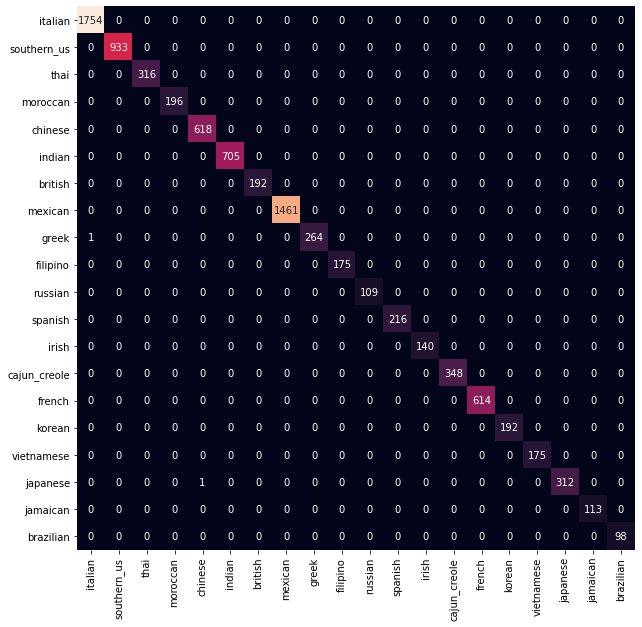

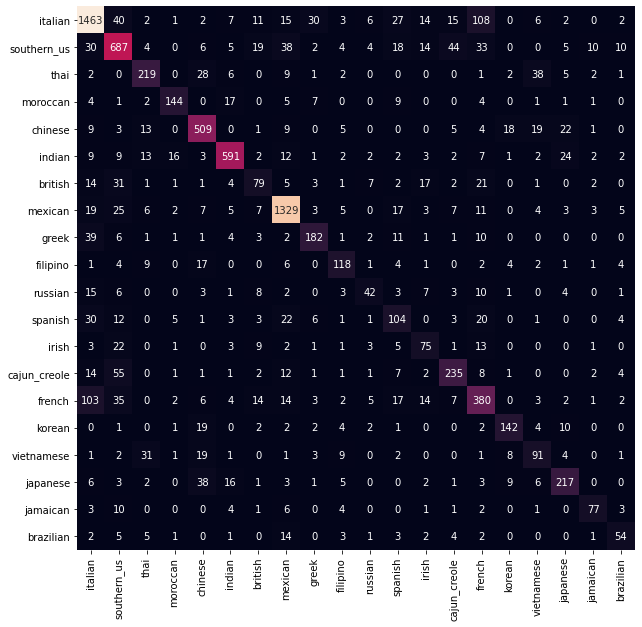

In [21]:
import seaborn as sb
import matplotlib.pyplot as plt

svm_confusion = [[0 for j in range(20)] for i in range(20)]
ann_confusion = [[0 for j in range(20)] for i in range(20)]


for i in range(len(predict_result_svm_test)):
    svm_confusion[valid_y[i]][predict_result_svm_test[i]] += 1


tick_label_list = []

for key,value in cuisine_dict.items():
    tick_label_list.append(key)

plt.figure(figsize = (10,10))
svm_heatmap = sb.heatmap(svm_confusion,xticklabels = tick_label_list,yticklabels = tick_label_list,annot=True,fmt='d',cbar=False)



for i in range(len(predict_result_ann_test)):
    ann_confusion[valid_y[i]][predict_result_ann_test[i]] += 1

plt.figure(figsize = (10,10))
ann_heatmap = sb.heatmap(ann_confusion,xticklabels = tick_label_list,yticklabels = tick_label_list,annot=True,fmt='d',cbar=False)

plt.show()



## accuracy

In [17]:
# SVM
accuracy_list_svm = 0
total_count_svm = 0
for i in range(len(svm_confusion)):
    accuracy_list_svm += svm_confusion[i][i]
    for j in range(len(svm_confusion[i])):
        total_count_svm += svm_confusion[i][j]

print("accuracy of SVM is :",accuracy_list_svm / total_count_svm)



# ANN
accuracy_list_ann = 0
total_count_ann = 0
for i in range(len(ann_confusion)):
    accuracy_list_ann += ann_confusion[i][i]
    for j in range(len(ann_confusion[i])):
        total_count_ann += ann_confusion[i][j]

print("accuracy of ANN is :",accuracy_list_ann / total_count_ann)

accuracy of SVM is : 0.9997761110489197
accuracy of ANN is : 0.75428187618941


## sensitivity(recall)

In [19]:
# SVM
print("recall of SVM\n")
recall_svm = [0 for i in range(20)]
for i in range(len(cuisine_dict)):
    tp_now = svm_confusion[i][i]
    total_count_now = 0
    for j in range(len(svm_confusion[i])):
        total_count_now += svm_confusion[i][j]
    recall_svm[i] += tp_now / total_count_now


for i in range(len(recall_svm)):
    print("recall of cuisine",list(cuisine_dict.keys())[list(cuisine_dict.values()).index(i)],":",recall_svm[i])

print("\n========================\n")

# ANN
print("recall of ANN")
recall_ann = [0 for i in range(20)]
for i in range(len(cuisine_dict)):
    tp_now = ann_confusion[i][i]
    total_count_now = 0
    for j in range(len(ann_confusion[i])):
        total_count_now += ann_confusion[i][j]
    recall_ann[i] += tp_now / total_count_now


for i in range(len(recall_ann)):
    print("recall of cuisine",list(cuisine_dict.keys())[list(cuisine_dict.values()).index(i)],":",recall_ann[i])

recall of SVM

recall of cuisine italian : 1.0
recall of cuisine southern_us : 1.0
recall of cuisine thai : 1.0
recall of cuisine moroccan : 1.0
recall of cuisine chinese : 1.0
recall of cuisine indian : 1.0
recall of cuisine british : 1.0
recall of cuisine mexican : 1.0
recall of cuisine greek : 0.9962264150943396
recall of cuisine filipino : 1.0
recall of cuisine russian : 1.0
recall of cuisine spanish : 1.0
recall of cuisine irish : 1.0
recall of cuisine cajun_creole : 1.0
recall of cuisine french : 1.0
recall of cuisine korean : 1.0
recall of cuisine vietnamese : 1.0
recall of cuisine japanese : 0.9968051118210862
recall of cuisine jamaican : 1.0
recall of cuisine brazilian : 1.0


recall of ANN
recall of cuisine italian : 0.8340935005701254
recall of cuisine southern_us : 0.7363344051446945
recall of cuisine thai : 0.6930379746835443
recall of cuisine moroccan : 0.7346938775510204
recall of cuisine chinese : 0.8236245954692557
recall of cuisine indian : 0.8382978723404255
recall o

## precision

In [23]:
# SVM
print("precision for SVM\n")
total_count_svm = [0 for i in range(len(cuisine_dict))]

for i in range(len(svm_confusion)):
    for j in range(len(svm_confusion[i])):
        total_count_svm[j] += svm_confusion[i][j] 


for i in range(len(cuisine_dict)):
    print("precision for cuisine",list(cuisine_dict.keys())[list(cuisine_dict.values()).index(i)],":",svm_confusion[i][i] / total_count_svm[i])

print("\n==========================\n")

# ANN
print("precision for ANN\n")
total_count_ann = [0 for i in range(len(cuisine_dict))]

for i in range(len(ann_confusion)):
    for j in range(len(ann_confusion[i])):
        total_count_ann[j] += ann_confusion[i][j] 


for i in range(len(cuisine_dict)):
    print("precision for cuisine",list(cuisine_dict.keys())[list(cuisine_dict.values()).index(i)],":",ann_confusion[i][i] / total_count_ann[i])

precision for SVM

precision for cuisine italian : 0.9994301994301994
precision for cuisine southern_us : 1.0
precision for cuisine thai : 1.0
precision for cuisine moroccan : 1.0
precision for cuisine chinese : 0.9983844911147012
precision for cuisine indian : 1.0
precision for cuisine british : 1.0
precision for cuisine mexican : 1.0
precision for cuisine greek : 1.0
precision for cuisine filipino : 1.0
precision for cuisine russian : 1.0
precision for cuisine spanish : 1.0
precision for cuisine irish : 1.0
precision for cuisine cajun_creole : 1.0
precision for cuisine french : 1.0
precision for cuisine korean : 1.0
precision for cuisine vietnamese : 1.0
precision for cuisine japanese : 1.0
precision for cuisine jamaican : 1.0
precision for cuisine brazilian : 1.0


precision for ANN

precision for cuisine italian : 0.8279569892473119
precision for cuisine southern_us : 0.7178683385579937
precision for cuisine thai : 0.711038961038961
precision for cuisine moroccan : 0.81355932203389

# 5. comparison & conclusion

For both SVM and ANN, because the dataset of trainning and testing are large enough to lower the efficiency of fitting, it takes a lot of time to test the effect of different value of various parameters to accuracy(SVM takes about 5 hours to test 4 kernel functions, while ANN takes much shorter).

For SVM, I used 4 kernel(linear, rbf, poly and sigmoid) to test the accuracy. According to the result, polynomial and rbf are the two functions which usually have highest accuracy. BTW, because testing parameters takes too much time(it takes at least 1 day to fit the svm with 4 kernel functions), I just set regularization parameter(which is C in short) to 100 and not set kernel coefficient for rbf, poly and sigmoid.

For ANN, I set three layers for the model, the input layer is a dense layer with input nueron number equals to the number of ingredient, and set output neuron number to half of the number of ingredient(That is, input neuron is about 6000 and output neuron is aobut 3000). The second layer is used to drop some neuron in order to prevent overfitting and will drop 20% of the neurons. The third layer(output layer) is the final calculation of probability of the current combination to its corresponding cuisine.

To my surprise, ANN always has better accuracy and lower time cost than SVM, perhaps it's because I don't adjust the parameter of SVM to the best.

# 6. Kaggle submission

the content of kaggle submission is in report